### SmartGuard: Federated Learning with Differential Privacy (Simulation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from copy import deepcopy

#### Simulation settings

In [2]:
NUM_CLIENTS = 5
NUM_ROUNDS = 10
NOISE_STD = 0.1  # Standard deviation for Gaussian noise (DP)
SAMPLES_PER_CLIENT = 100
FEATURES = 10


#### Step 1: Generate synthetic data per client (simulate mobile devices)

In [3]:
clients_data = [make_classification(n_samples=SAMPLES_PER_CLIENT, 
                                     n_features=FEATURES, 
                                     n_informative=5, 
                                     n_classes=2, 
                                     random_state=i) 
                for i in range(NUM_CLIENTS)]

####  Step 2: Initialize the global model and pre-train once (to set class labels)

In [4]:
global_model = LogisticRegression(solver='saga', max_iter=1000)
X_all = np.vstack([c[0] for c in clients_data])
y_all = np.hstack([c[1] for c in clients_data])
global_model.fit(X_all, y_all)


LogisticRegression(max_iter=1000, solver='saga')

####  Step 3: Zero out initial weights (fresh start)

In [5]:
global_model.coef_ = np.zeros_like(global_model.coef_)
global_model.intercept_ = np.zeros_like(global_model.intercept_)

####  Step 4: Run Federated Learning with Differential Privacy

In [6]:
accuracies = []

for round in range(NUM_ROUNDS):
    client_weights = []

    for X, y in clients_data:
        # Local training on client's data
        local_model = deepcopy(global_model)
        local_model.fit(X, y)

        # Add Gaussian noise (DP) to model weights
        noisy_weights = local_model.coef_ + np.random.normal(0, NOISE_STD, size=local_model.coef_.shape)
        noisy_intercept = local_model.intercept_ + np.random.normal(0, NOISE_STD, size=local_model.intercept_.shape)
        client_weights.append((noisy_weights, noisy_intercept))

    # Federated Averaging
    avg_weights = np.mean([w[0] for w in client_weights], axis=0)
    avg_intercept = np.mean([w[1] for w in client_weights], axis=0)
    global_model.coef_ = avg_weights
    global_model.intercept_ = avg_intercept

    # Evaluate on combined dataset
    y_pred = global_model.predict(X_all)
    acc = accuracy_score(y_all, y_pred)
    accuracies.append(acc)
    print(f"Round {round+1}: Accuracy = {acc:.4f}")

Round 1: Accuracy = 0.6420
Round 2: Accuracy = 0.6500
Round 3: Accuracy = 0.6460
Round 4: Accuracy = 0.6480
Round 5: Accuracy = 0.6480
Round 6: Accuracy = 0.6580
Round 7: Accuracy = 0.6500
Round 8: Accuracy = 0.6560
Round 9: Accuracy = 0.6360
Round 10: Accuracy = 0.6460


#### Step 5: Plot accuracy over federated rounds

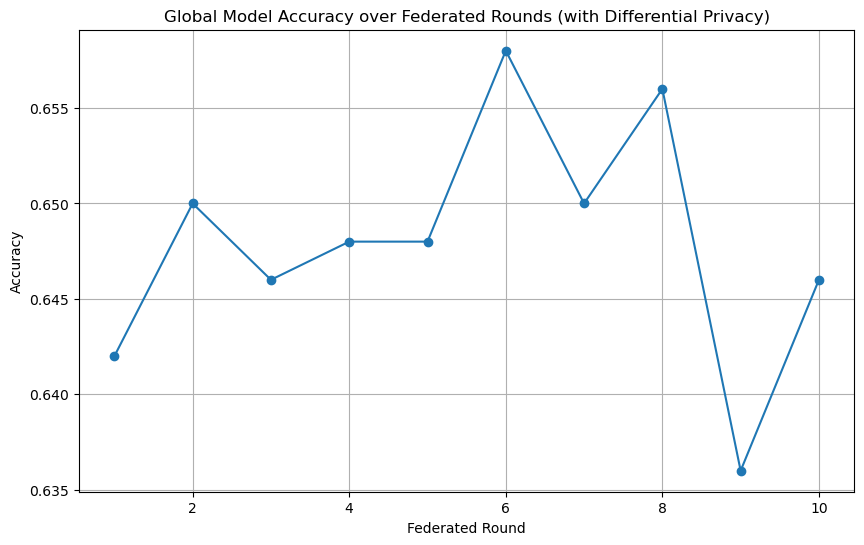

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_ROUNDS + 1), accuracies, marker='o')
plt.title('Global Model Accuracy over Federated Rounds (with Differential Privacy)')
plt.xlabel('Federated Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
